### Import the relevant packages 

In [58]:
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset, DataLoader

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

### Reading the tumor MRI images 

In [59]:
tumor = []
path_to_tumor_images = glob.iglob('./data/brain_tumor_dataset/yes/*.jpg')

for file in path_to_tumor_images:
    img = cv2.imread(file)

    # resizing the image
    img = cv2.resize(img, (128, 128))

    # reordering the color channels
    b, g, r = cv2.split(img)
    img = cv2.merge([r, g, b])

    tumor.append(img)


print(f'Number of tumor images: {len(tumor)}')

Number of tumor images: 154


### Reading the healthy MRI images

In [60]:
no_tumor = []
path_to_no_tumor_images = glob.iglob('./data/brain_tumor_dataset/no/*.jpg')

for file in path_to_no_tumor_images:
    img = cv2.imread(file)

    # resizing the image
    img = cv2.resize(img, (128, 128))

    # reordering the color channels
    b, g, r = cv2.split(img)
    img = cv2.merge([r, g, b])

    no_tumor.append(img)


print(f'Number of healthy images: {len(no_tumor)}')

Number of healthy images: 91


### Converting the lists of images to numpy arrays

In [61]:
tumor = np.array(tumor)
no_tumor = np.array(no_tumor)

### Taking a look at the dimensions of the arrays

In [62]:
print(f"Shape of tumor images array: {tumor.shape}")
print(f"Number of images: {tumor.shape[0]}")
print(f"Number of channels: {tumor.shape[3]} (RGB)")
print(f"Size of each channel: {tumor.shape[1]} x {tumor.shape[2]}")

print("\n")

print(f"Shape of no tumor images array: {no_tumor.shape}")
print(f"Number of images: {no_tumor.shape[0]}")
print(f"Number of channels: {no_tumor.shape[3]} (RGB)")
print(f"Size of each channel: {no_tumor.shape[1]} x {no_tumor.shape[2]}")

Shape of tumor images array: (154, 128, 128, 3)
Number of images: 154
Number of channels: 3 (RGB)
Size of each channel: 128 x 128


Shape of no tumor images array: (91, 128, 128, 3)
Number of images: 91
Number of channels: 3 (RGB)
Size of each channel: 128 x 128


### Visualizing some of the MRI images 

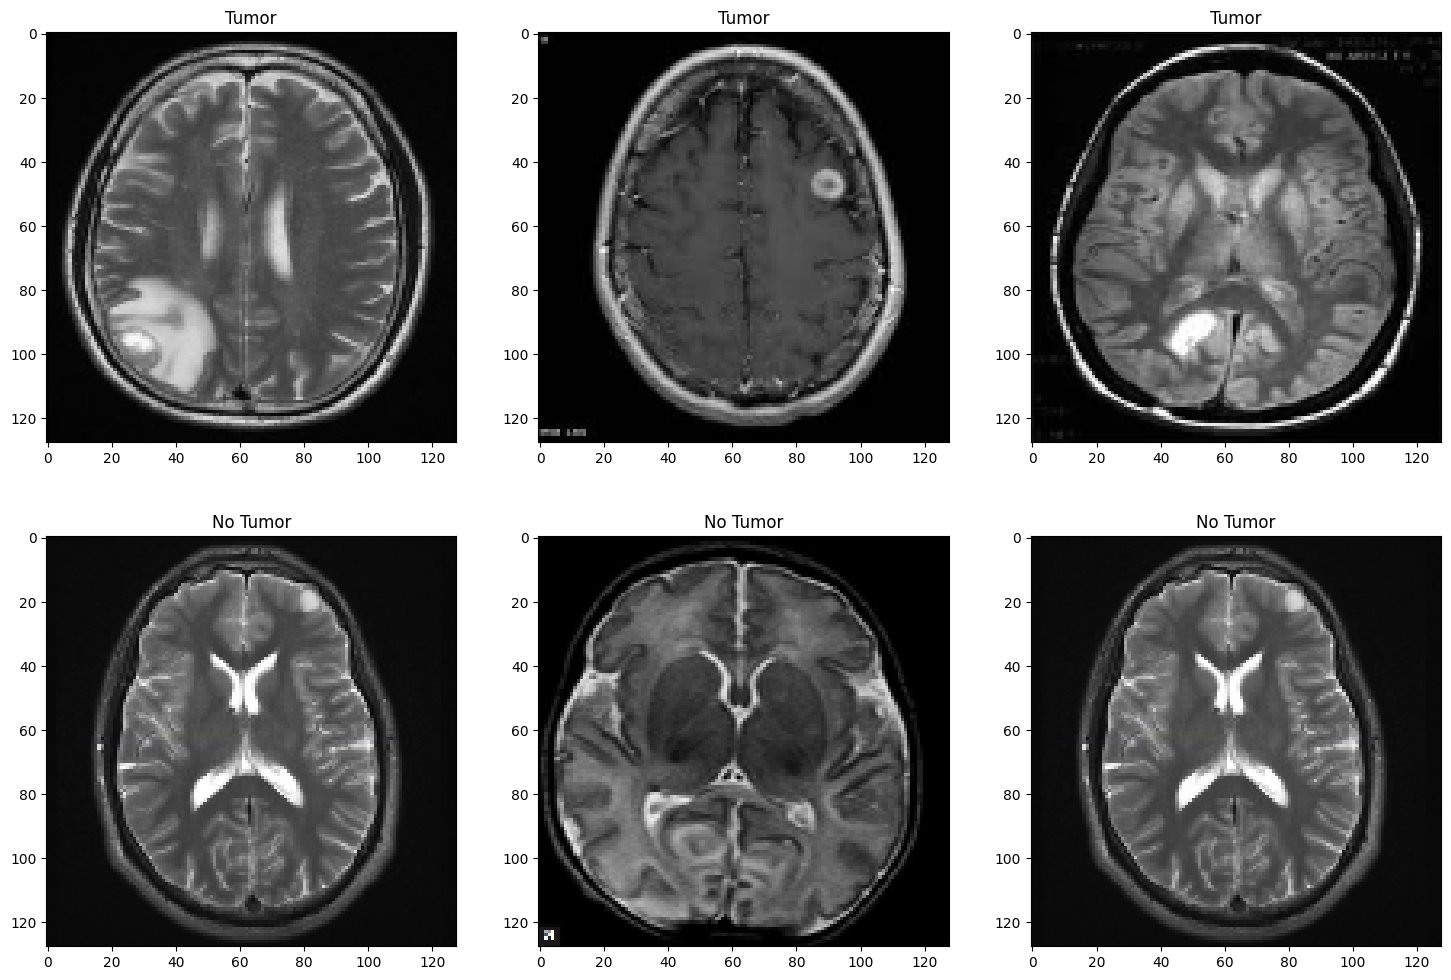

In [63]:
# initialize the plot
plt.figure(figsize=(18, 12))

for i in range(3):
    # tumor images
    plt.subplot(2, 3, i+1)
    plt.title('Tumor')
    plt.imshow(tumor[random.randint(0, len(tumor)-1)])

    # no_tumor images
    plt.subplot(2, 3, i+4)
    plt.title('No Tumor')
    plt.imshow(no_tumor[random.randint(0, len(no_tumor)-1)])

### Creating a custom pytorch Dataset class

In [64]:
class MRI(Dataset):

    def __init__(self, images, labels):
        """Initializes the object. """
        # reorder the images array from (#images, h, w, #channels) to (#images, #channels, h, w)
        images = images.reshape((images.shape[0],images.shape[3],images.shape[1],images.shape[2]))

        self.images = images
        self.labels = labels

    def __len__(self):
        """Returns the amount of images in the dataset. """
        return self.images.shape[0]

    def __getitem__(self, index):
        """Returns a custom representation of the data inside the object. """
        # convert the values inside the arrays to float32 as that is what the model expects later during training
        item = {"image": self.images[index].astype(np.float32), "label": self.labels[index].astype(np.float32)}
        return item

    def normalize(self):
        """Normalizes the images (optional). """
        self.images = self.images / 255.0


### Getting the data ready for the custom dataset

In [65]:
# create arrays for the labels
tumor_labels = np.ones(tumor.shape[0])
no_tumor_labels = np.zeros(no_tumor.shape[0])

# combine the images into one array for the dataset
combined_images = np.concatenate((tumor, no_tumor), axis=0)

# combine the labels into one array for the dataset
combined_labels = np.concatenate((tumor_labels, no_tumor_labels))

### Putting the arrays of MRI images into the custom dataset

In [66]:
# create an MRI object from the custom dataclass by giving it the images and labels
mri_dataset = MRI(images=combined_images, labels=combined_labels)

# execute the normalize function of the MRI class
mri_dataset.normalize()

### Defining a neural network class

In [67]:
class CNN(nn.Module):

    def __init__(self):

        # initialize the super class
        super(CNN, self).__init__()

        # define the neural network structure
        self.cnn_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=5),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=5)
        )

        # define the fully connected (fc) model structure
        self.fc_model = nn.Sequential(
            nn.Linear(in_features=256, out_features=120),
            nn.Tanh(),
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=1),
        )

    # define the forward propagation
    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        x = F.sigmoid(x)

        return x

### Switching the device used by pytorch to the GPU of the system

In [68]:
# check if the systems graphics processing unit allows for CUDA
torch.cuda.is_available()

# get the GPU as the device for pytorch
device = torch.device('cuda:0')

# tell the model to run on the GPU
model = CNN().to(device)

### Setting hyperparameters for the model training

In [69]:
# set the learning rate
eta = 0.0001

# set the epochs / amount of passes through the entire dataset
EPOCH = 700

# choose the popular Adam algorithm as the optimization technique
optimizer = torch.optim.Adam(model.parameters(), lr=eta)

# use the DataLoader from pytorch to grab batches of 32 random images
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)

# set the model to training mode
model.train()

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

### Training the model

In [70]:
for epoch in range(1, EPOCH):

  losses = []

  # for each batch of 32 images and labels
  for D in dataloader:

    # reset gradients to zero before processing the current batch
    optimizer.zero_grad()

    # extract the images and labels and move them over to the device (GPU)
    data = D['image'].to(device)
    label = D['label'].to(device)

    # pass the data through the model to get the predictions
    y_hat = model(data)

    # define Binary Cross Entropy Loss as the loss function
    error = nn.BCELoss()

    # calculate the total loss for the batch by summing the individual losses per image
    loss = torch.sum(error(y_hat.squeeze(), label))

    # perform backpropagation to calculate gradients based on the current batch loss
    loss.backward()

    # update the model parameters using the calculated gradients and the optimizer algorithm
    optimizer.step()

    # append the current batch loss to the losses list
    losses.append(loss.item())

  # print the training epoch number and average loss every 10 epochs
  if (epoch+1) % 10 == 0:
    print('Train Epoch: {}\tLoss: {:.6f}'.format(epoch+1, np.mean(losses)))

Train Epoch: 10	Loss: 0.632063
Train Epoch: 20	Loss: 0.612044
Train Epoch: 30	Loss: 0.552808
Train Epoch: 40	Loss: 0.528959
Train Epoch: 50	Loss: 0.522817
Train Epoch: 60	Loss: 0.493012
Train Epoch: 70	Loss: 0.462600
Train Epoch: 80	Loss: 0.465027
Train Epoch: 90	Loss: 0.429457
Train Epoch: 100	Loss: 0.415242
Train Epoch: 110	Loss: 0.403222
Train Epoch: 120	Loss: 0.393840
Train Epoch: 130	Loss: 0.385516
Train Epoch: 140	Loss: 0.349491
Train Epoch: 150	Loss: 0.325717
Train Epoch: 160	Loss: 0.315194
Train Epoch: 170	Loss: 0.289916
Train Epoch: 180	Loss: 0.274950
Train Epoch: 190	Loss: 0.249732
Train Epoch: 200	Loss: 0.230716
Train Epoch: 210	Loss: 0.219090
Train Epoch: 220	Loss: 0.237237
Train Epoch: 230	Loss: 0.183508
Train Epoch: 240	Loss: 0.176225
Train Epoch: 250	Loss: 0.152929
Train Epoch: 260	Loss: 0.135112
Train Epoch: 270	Loss: 0.121549
Train Epoch: 280	Loss: 0.120404
Train Epoch: 290	Loss: 0.092005
Train Epoch: 300	Loss: 0.077427
Train Epoch: 310	Loss: 0.066774
Train Epoch: 320	

### Evaluating the model

In [71]:
# switch the model from training mode to evaluation mode
model.eval()

dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)

outputs = []
y_true = []

# disable gradient calculation temporarily
with torch.no_grad():

    for D in dataloader:
        # extract the images and labels and move them over to the device (GPU)
        image = D['image'].to(device)
        label = D['label'].to(device)

        # pass the data through the model to get the predictions
        y_hat = model(image)

        # store the predictions and true labels for later analysis
        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())

# concatenate the collected predictions and true labels from all batches into single NumPy array
outputs = np.concatenate(outputs, axis=0)
y_true = np.concatenate(y_true, axis=0)

### Defining a binary threshold 

In [72]:
def binary_threshold(scores, threshold=0.50, minimum=0, maximum=1.0):
    """This function takes a list of scores and applies a binary threshold to them."""

    # Convert input to a NumPy array for efficient processing
    x = np.array(list(scores))

    # Scores above/equal threshold set to maximum
    x[x >= threshold] = maximum

    # Scores below threshold set to minimum
    x[x < threshold] = minimum

    return x

## Testing the accuracy of the model on the data it was trained on

In [73]:
accuracy_score(y_true, binary_threshold(outputs))

1.0

### Plotting a confusion matrix for the model evaluation

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

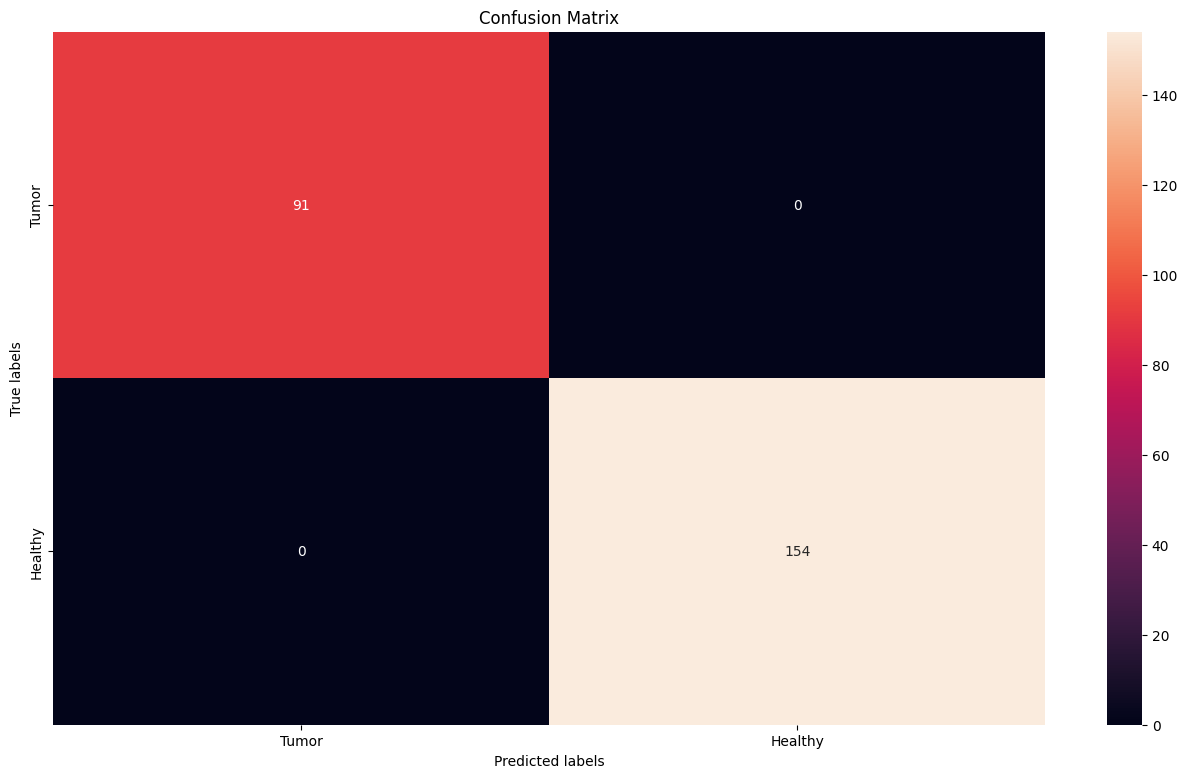

In [74]:
# create the confusion matrix
cm = confusion_matrix(y_true, binary_threshold(outputs))

# define the size of the matplotlib plot
plt.figure(figsize=(16,9))

# create a heatmap
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)

# customize the labels and title
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# set tick labels for readability
ax.xaxis.set_ticklabels(['Tumor','Healthy'])
ax.yaxis.set_ticklabels(['Tumor','Healthy'])

### Visualizing the prediction scores of the model output

The graph shows the prediction score output of the model for each input. 

Judging by how most of the values are quite close to either 0.0 or 1.0, the model is quite accurate in predicting if a given image is a healthy brain or not. 

The dashed red line indicates where the input images switched from tumor images to healthy ones. 



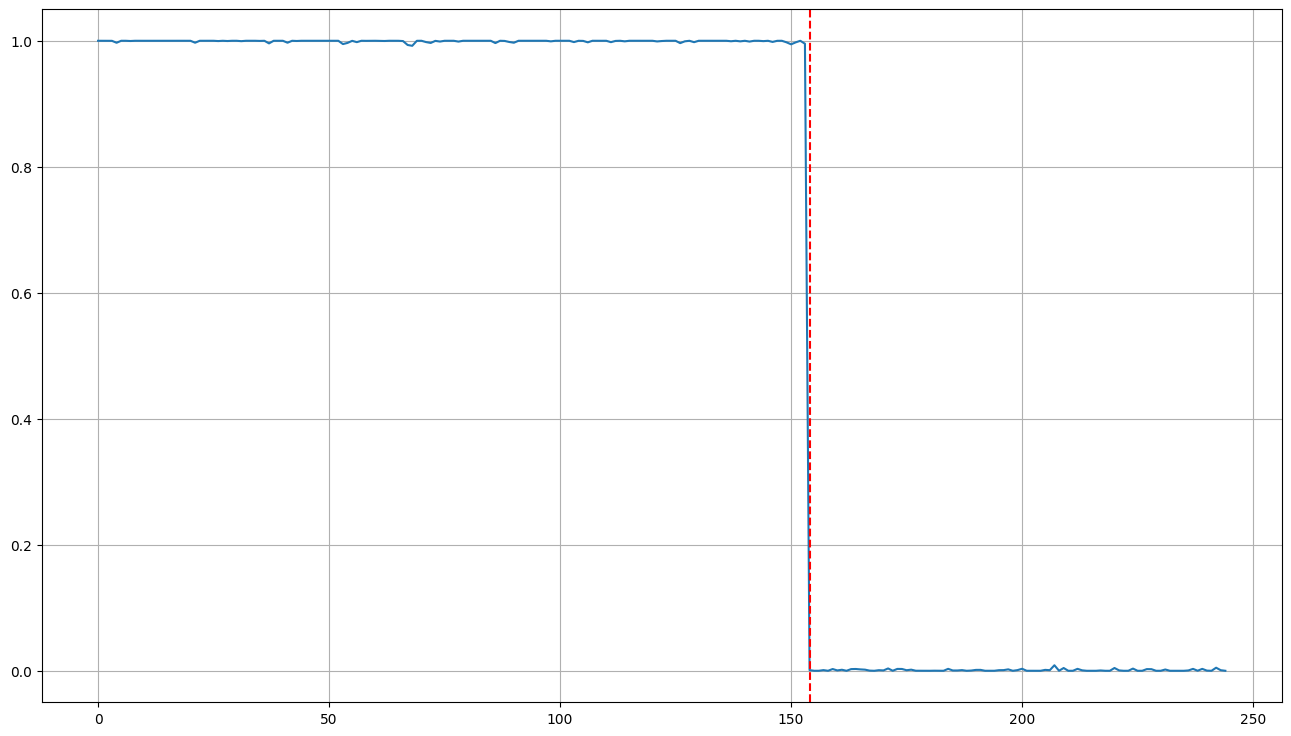

In [75]:
# define the size of the matplotlib plot
plt.figure(figsize=(16,9))

# visualize model outputs as a line plot
plt.plot(outputs)

# add a vertical dashed red line at a specific x-axis position (indicating where the images go from tumor to healthy)
plt.axvline(x=len(tumor), color='r', linestyle='--')

# add gridlines for readability
plt.grid()